# Assignment 1

DATASET (MNIST): http://yann.lecun.com/exdb/mnist/

Train 1 denoising and 1 contractive autoencoder on the MNIST dataset. It is up to you to decide how many layers and neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different autoencoders.

Then, experiment with what happens if you feed the autoencoders with a random noise image and then you apply the iterative gradient ascent process described in the lecture to see if the reconstruction converges to the data manifold. Confront the reconstructions created by the 2 different models and comment on the results.

In [24]:
import torch
import itertools as it

from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self,encoder_sizes,decoder_sizes):
        super(AutoEncoder, self).__init__()
        encoder_layers=[]
        for sx,dx in it.pairwise(encoder_sizes):
            encoder_layers.append(nn.Linear(sx,dx))
            encoder_layers.append(nn.ReLU())
        decoder_layers=[]
        for sx,dx in it.pairwise(decoder_sizes[:-1]):
            decoder_layers.append(nn.Linear(sx,dx))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_sizes[-2],decoder_sizes[-1]))
        decoder_layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(
            *encoder_layers
        )
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded.retain_grad()
        decoded = self.decoder(encoded)
        return encoded, decoded

In [25]:

import torchvision
import torchvision.transforms as transforms
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataset.requires_grad=True
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
import matplotlib.pyplot as plt 




def train_denoising_ae(ae,data,n_epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for sample in data:
            img, _ = sample
            img_noisy = img + torch.randn(img.size())
            img_noisy = img_noisy.view(-1, 28*28)
            img = img.view(-1, 28*28)
            optimizer.zero_grad()

            img=img.to(DEVICE)
            img_noisy=img_noisy.to(DEVICE)
            _, output = ae(img_noisy)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            MSE_loss = nn.MSELoss()(output, img)
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{MSE_loss.item():.4f}')
dae=AutoEncoder([28*28, 256, 64], [64,256, 28*28]).to(DEVICE)
train_denoising_ae(dae,dataloader,20)

epoch [1/20], loss:0.0426
epoch [2/20], loss:0.0362
epoch [3/20], loss:0.0334
epoch [4/20], loss:0.0322
epoch [5/20], loss:0.0305
epoch [6/20], loss:0.0314
epoch [7/20], loss:0.0301
epoch [8/20], loss:0.0295
epoch [9/20], loss:0.0285
epoch [10/20], loss:0.0296
epoch [11/20], loss:0.0285
epoch [12/20], loss:0.0294
epoch [13/20], loss:0.0289
epoch [14/20], loss:0.0273
epoch [15/20], loss:0.0272
epoch [16/20], loss:0.0283
epoch [17/20], loss:0.0269
epoch [18/20], loss:0.0267
epoch [19/20], loss:0.0267
epoch [20/20], loss:0.0272


In [42]:
def contractive_loss(encoder_output,criterion, inputs,outputs,contractive_penalty):
    """ jacobian = torch.autograd.grad(outputs=hidden, inputs=inputs,
                                   grad_outputs=torch.ones_like(hidden),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
    jacobian = jacobian.view(jacobian.size(0), -1)
    penalty_term = torch.norm(jacobian, p=2, dim=1)**2 """
    loss1=criterion(outputs,inputs)
    encoder_output.backward(torch.ones(encoder_output.size()).to(DEVICE), retain_graph=True)
    loss2= torch.sqrt(torch.sum(torch.pow(inputs.grad,2)))
    return loss1+(contractive_penalty*loss2)

def train_contractive_ae(ae,data,n_epochs=10,contractive_penalty=1e-10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for i,sample in enumerate(data):
            batch, _ = sample
            batch = batch.view(-1, 28*28).to(DEVICE)
            
            batch.requires_grad = True
            batch.retain_grad()
            hidden, output = ae(batch)
            loss=contractive_loss(hidden,nn.BCELoss(),batch,output,contractive_penalty)
            #loss = criterion(output, batch) + contractive_penalty * jacobian_penalty_term(ae, batch)
            batch.requires_grad=False
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{loss.item():.4f}')
#needed in order to compute the jacobian

cae=AutoEncoder([28*28, 256, 64], [64, 256, 28*28]).to(DEVICE)
train_contractive_ae(cae,dataloader,100)

epoch [1/100], loss:0.1515
epoch [2/100], loss:0.1170
epoch [3/100], loss:0.1050
epoch [4/100], loss:0.0979
epoch [5/100], loss:0.0942
epoch [6/100], loss:0.0916
epoch [7/100], loss:0.0892
epoch [8/100], loss:0.0872
epoch [9/100], loss:0.0855
epoch [10/100], loss:0.0843
epoch [11/100], loss:0.0834
epoch [12/100], loss:0.0827
epoch [13/100], loss:0.0820
epoch [14/100], loss:0.0814
epoch [15/100], loss:0.0809
epoch [16/100], loss:0.0804
epoch [17/100], loss:0.0799
epoch [18/100], loss:0.0796
epoch [19/100], loss:0.0792
epoch [20/100], loss:0.0789
epoch [21/100], loss:0.0786
epoch [22/100], loss:0.0783
epoch [23/100], loss:0.0781
epoch [24/100], loss:0.0778
epoch [25/100], loss:0.0777
epoch [26/100], loss:0.0775
epoch [27/100], loss:0.0774
epoch [28/100], loss:0.0772
epoch [29/100], loss:0.0771
epoch [30/100], loss:0.0770
epoch [31/100], loss:0.0769
epoch [32/100], loss:0.0768
epoch [33/100], loss:0.0767
epoch [34/100], loss:0.0766
epoch [35/100], loss:0.0765
epoch [36/100], loss:0.0764
e

In [59]:
def generate_data_point(model, noise, num_iterations=100):
    old_noise=noise
    diff=1
    # Start with a random noise
    while(diff > 1e-3):
        # Forward pass through the encoder
        old_noise=noise
        _,noise = model(old_noise)
        diff=torch.norm(noise-old_noise,p=2)
        print(diff)
    new_data_point= noise.view(-1, 28*28)
    return new_data_point

In [60]:
import matplotlib.pyplot as plt
noise=torch.randn((28*28)).requires_grad_(True).to(DEVICE)

plt.matshow(generate_data_point(cae,noise,200000).view(28, 28).detach().cpu().numpy(),cmap='gray')

tensor(28.7287, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(3.2964, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.4269, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(2.4545, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(2.4368, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.6537, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.4331, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.8419, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5582, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5806, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7567, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7152, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.6311, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5924, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.5093, device='cuda:0', g

KeyboardInterrupt: 

tensor(27.6226, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(2.2617, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.7442, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(1.4511, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.8327, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.3210, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.1229, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0778, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0694, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0713, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0732, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0760, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.0790, device='cuda:0', g

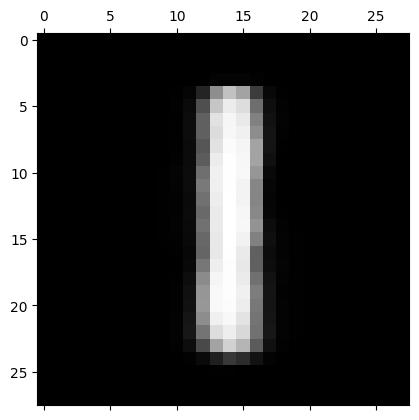

In [58]:
plt.matshow(generate_data_point(dae,noise,100000).view(28, 28).detach().cpu().numpy(),cmap='gray')